In [18]:
import pystac_client
import planetary_computer
import folium
import geopandas as gpd
import leafmap.foliumap as leafmap
#leafmap.search_qms(keyword="google")

In [19]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [20]:
nepal = gpd.read_file("../data/nepal/landuse.shp")
forest = nepal[nepal["Category"]=="Forest"].reset_index(drop=True)
forest.head(3)

,fid,FCODE,Category,Shape_Leng,Shape_Le_1,Shape_Area,LakeName,geometry
0,2666,25212.0,Forest,525.623365,525.623365,0.006189,None,"POLYGON ((83.86829 28.3053, 83.86844 28.30611,..."
1,789,25212.0,Forest,5833.769583,5833.769583,0.495647,None,"POLYGON ((83.67782 28.83034, 83.67792 28.83043..."
2,792,25212.0,Forest,953.427661,953.427661,0.032157,None,"POLYGON ((83.68051 28.83133, 83.68051 28.83129..."


In [21]:
#center of each polygon 
forest_mapping = forest[5:10]
forest_mapping['centroid'] = forest_mapping['geometry'].centroid
forest_mapping['Lon'] = forest_mapping['centroid'].x
forest_mapping['Lat'] = forest_mapping['centroid'].y

# Create a map and check the location of each cluster
center_lat, center_lon =  forest_mapping['Lat'].mean(), forest_mapping['Lon'].mean()

m = leafmap.Map(location=[center_lat, center_lon], zoom_start=14)
m.add_xyz_service("qms.EOX::Maps - Sentinel-2 cloudless")

# Add markers for each point on the map
for _, row in forest_mapping.iterrows():
    folium.Marker(location=[row['Lat'], row['Lon']]).add_to(m)

style_function = lambda x: {'fillColor': '#3366cc', 'color': '#3366cc'}
folium.GeoJson(forest_mapping['geometry'], style_function=style_function).add_to(m)
# Display the map
m

### MODIS - FAPAR

In [5]:
# Nepal 
bbox = [80.0884245137, 26.3978980576, 88.1748043151, 30.4227169866]

In [6]:
search = catalog.search(
    collections="modis-15A2H-061",
    datetime="2023-08-01/2023-08-30",
    bbox=bbox
)
items = list(search.items())
print(f"Found {len(items)} items:")

Found 60 items:


In [10]:
import odc.stac
data = odc.stac.load(
    items,
    crs="EPSG:3857", #4326  3857
    bands="Fpar_500m",
    resolution=500,
    bbox=bbox,
)

forest = forest.to_crs(epsg=3857)
raster = items[2].assets["Fpar_500m"].extra_fields["raster:bands"]
data = data * raster[0]["scale"]

In [11]:
data

<xarray.Dataset> Size: 74MB
Dimensions:      (y: 1020, x: 1802, time: 5)
Coordinates:
  * y            (y) float64 8kB 3.558e+06 3.557e+06 ... 3.049e+06 3.048e+06
  * x            (x) float64 14kB 8.915e+06 8.916e+06 ... 9.815e+06 9.816e+06
    spatial_ref  int32 4B 3857
  * time         (time) datetime64[ns] 40B 2023-07-28 2023-08-05 ... 2023-08-29
Data variables:
    Fpar_500m    (time, y, x) float64 74MB 0.05 2.53 0.06 2.53 ... 0.65 0.65 0.7

### XVec - Spatial_agg
**Aggregate raster data cube using vector geometries to have vector data cube**

In [12]:
import xvec

In [13]:
%%time
aggregated = data.xvec.zonal_stats(
    forest.geometry,
    x_coords="x", 
    y_coords="y",
    stats=[
        "mean",
        "min",
        "max"
    ], 
)
aggregated

CPU times: user 344 ms, sys: 30.7 ms, total: 375 ms
Wall time: 373 ms


<xarray.Dataset> Size: 40kB
Dimensions:           (time: 5, zonal_statistics: 3, geometry: 308)
Coordinates:
  * time              (time) datetime64[ns] 40B 2023-07-28 ... 2023-08-29
  * zonal_statistics  (zonal_statistics) <U4 48B 'mean' 'min' 'max'
    spatial_ref       int32 4B 3857
  * geometry          (geometry) object 2kB POLYGON ((9336174.876719626 32875...
Data variables:
    Fpar_500m         (geometry, zonal_statistics, time) float64 37kB nan ......
Indexes:
    geometry  GeometryIndex (crs=EPSG:3857)

### Indexing and Selecting

In [14]:
forest.head(5)

,fid,FCODE,Category,Shape_Leng,Shape_Le_1,Shape_Area,LakeName,geometry
0,2666,25212.0,Forest,525.623365,525.623365,0.006189,None,"POLYGON ((9336174.877 3287520.526, 9336191.751..."
1,789,25212.0,Forest,5833.769583,5833.769583,0.495647,None,"POLYGON ((9314972.393 3354069.165, 9314983.662..."
2,792,25212.0,Forest,953.427661,953.427661,0.032157,None,"POLYGON ((9315272.134 3354194.959, 9315271.469..."
3,793,25212.0,Forest,12770.410694,12770.410694,1.568471,None,"POLYGON ((9315978.474 3353030.504, 9315980.906..."
4,799,25212.0,Forest,3338.020384,3338.020384,0.313117,None,"POLYGON ((9314660.251 3352909.142, 9314661.877..."


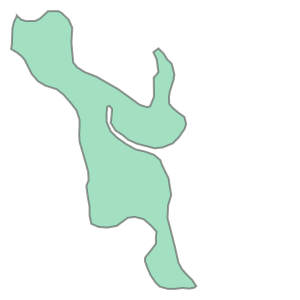

In [15]:
# Select the forest by id
forest_id = 789

# Filter the GeoDataFrame to get the row corresponding to the specific district
forest_row = forest[forest['fid'] == forest_id] 

# Extract the geometry of the specific district
forest_geometry = forest_row.geometry.iloc[0]
forest_geometry

In [16]:
aggregated.sel(geometry=forest_geometry)

<xarray.Dataset> Size: 220B
Dimensions:           (time: 5, zonal_statistics: 3)
Coordinates:
  * time              (time) datetime64[ns] 40B 2023-07-28 ... 2023-08-29
  * zonal_statistics  (zonal_statistics) <U4 48B 'mean' 'min' 'max'
    spatial_ref       int32 4B 3857
    geometry          object 8B POLYGON ((9314972.393283298 3354069.165029122...
Data variables:
    Fpar_500m         (zonal_statistics, time) float64 120B 0.6267 0.04 ... 0.79